In [137]:
import ee
ee.Initialize()

import geemap
import pandas as pd
import geopandas as gpd
import numpy as np 

import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix

pd.options.display.float_format = '{:.3f}'.format

## 1 - input parameters

In [138]:
ISO = 'CMR'

In [139]:
classified_image = ee.Image('projects/ee-cocoacmr/assets/outputs/CMR_forest_types_v4')
#classified_image = ee.Image('projects/ee-cocoacmr/assets/outputs/CMR_GIEC_v4')

In [140]:
# resolution of the map
scale = 10

In [141]:
# band name for classification
map_band = 'classification'
#map_band = 'remapped'

In [142]:
# list of class codes
#labels = [1,2,3,4,7,8,9,10,11,12,13,14,15,16,17,18]
labels = [11,12,13,14,15,22,30,41,42,50,60]
#labels = [10,20,30,40,50,60]

In [143]:
# CEO data
interpretedData = pd.read_csv('/home/sepal-user/COCAFORI/CMR_LC_validated.csv', low_memory=False)
interpretedData.columns

Index(['index', 'plotid', 'sampleid', 'sample_internal_id', 'lon', 'lat',
       'flagged', 'collection_time', 'sample_geom', 'pl_index', 'pl_jrcmap',
       'pl_tcc', 'Map2020_class', 'GIEC', 'FType_2020', 'AgType_2020',
       'HumType_2020', 'collection', 'interpreted', 'GIEC_2020_code',
       'FType_2020_code', 'AgType_2020_code', 'HumType_2020_code',
       'Class_2020_Ref'],
      dtype='object')

In [144]:
# column with LC code
ref_column = 'Class_2020_Ref'
#ref_column = 'GIEC_2020_code'

In [145]:
# name out class area outputs file
area_out = '/home/sepal-user/COCAFORI/CMR_2020_LC_types_areas.csv'

In [146]:
#name of output file with reference and map data
table_out = '/home/sepal-user/COCAFORI/CMR_2020_LC_types_ceo_ref_val.csv'

In [147]:
#name of output error matrix
matrix_out = '/home/sepal-user/COCAFORI/CMR_2020_LC_types_ref_val_matrix.csv'

### 2 - Get map areas

In [148]:
# Add the area for each pixel
pixelArea = ee.Image.pixelArea()
# Multiply pixel area by the class to get the area per class
area_image = pixelArea.addBands(classified_image)

In [149]:
# Reduce the region by summing up the areas per class
class_areas = area_image.reduceRegion(
    reducer=ee.Reducer.sum().group(groupField=1, groupName='class'),
    geometry=classified_image.geometry(),
    scale=30,  # Adjust scale according to your image resolution
    maxPixels=1e12
)

In [150]:
# Assuming class_areas is already defined and contains the necessary data
class_areas_dict = class_areas.getInfo()

# Prepare the data for the DataFrame
data = []
for item in class_areas_dict['groups']:
    area_ha = item['sum'] / 10000  # Convert square meters to hectares
    data.append({
        'Class': item['class'],
        'Area (ha)': area_ha
    })

# Convert the list of dictionaries to a DataFrame
areas_df = pd.DataFrame(data)

# Display the DataFrame
print(areas_df)

    Class    Area (ha)
0      11 28129821.659
1      12  3202262.563
2      13  1404152.652
3      14   192847.083
4      15  1728506.110
5      22  2921420.726
6      30  8358410.755
7      41   575011.480
8      42   426873.266
9      50   554966.680
10     60    91343.085


### 3 sample map with validation points 

In [151]:
gdf = gpd.GeoDataFrame(interpretedData[['index', 'plotid', 'sampleid', 'collection', ref_column, 'lon', 'lat']], geometry=gpd.points_from_xy(interpretedData.lon, interpretedData.lat), crs='epsg:4326')
gdf

,index,plotid,sampleid,collection,Class_2020_Ref,lon,lat,geometry
0,0,2,2,1,30,13.157,9.445,POINT (13.15682 9.44489)
1,1,4,4,1,12,14.299,7.777,POINT (14.29857 7.77672)
2,2,7,7,1,30,14.741,11.144,POINT (14.74055 11.14450)
3,3,6,6,1,30,13.760,8.647,POINT (13.75959 8.64718)
4,4,8,8,1,11,13.101,4.403,POINT (13.10112 4.40264)
...,...,...,...,...,...,...,...,...
1372,1372,798,798,2,11,14.997,2.592,POINT (14.99742 2.59231)
1373,1373,799,799,2,11,11.844,4.320,POINT (11.84388 4.32031)
1374,1374,795,795,2,11,10.006,3.522,POINT (10.00584 3.52171)
1375,1375,801,801,2,11,13.178,2.911,POINT (13.17761 2.91113)


### be patient this can take a while with a large number of points

In [152]:
dfs = []
for i in range(0, len(interpretedData), 5000):
    tmp_df = gdf.loc[i:i+4999]
    tmp_fc = geemap.gdf_to_ee(tmp_df[['index','plotid', 'sampleid', 'collection', ref_column, 'geometry']])
    tmp_smp = classified_image.select(map_band).reduceRegions(**{
        'collection': tmp_fc,
        'scale': scale,
        'reducer': ee.Reducer.first()   
    })

    tmp_res = geemap.ee_to_gdf(tmp_smp)
    dfs.append(tmp_res)
    
results_df = pd.concat(dfs)
#results_df.to_csv(table_out, index=False)

In [153]:
results_df = results_df.rename(columns={'first':'Class_2020_Map'})
#results_df = results_df.rename(columns={'first':'Map_GIEC'})
results_df

,geometry,Class_2020_Ref,collection,Class_2020_Map,index,plotid,sampleid
0,POINT (13.15682 9.44489),30,1,30,0,2,2
1,POINT (14.29857 7.77672),12,1,11,1,4,4
2,POINT (14.74055 11.14450),30,1,30,2,7,7
3,POINT (13.75959 8.64718),30,1,30,3,6,6
4,POINT (13.10112 4.40264),11,1,11,4,8,8
...,...,...,...,...,...,...,...
1372,POINT (14.99742 2.59231),11,2,11,1372,798,798
1373,POINT (11.84388 4.32031),11,2,11,1373,799,799
1374,POINT (10.00584 3.52171),11,2,11,1374,795,795
1375,POINT (13.17761 2.91113),11,2,11,1375,801,801


In [154]:
#export talbe with map and reference
results_df.to_csv(table_out,index=False)

In [155]:
conf_matrix = confusion_matrix(results_df[ref_column], results_df[ref_column], labels=labels)

In [156]:
cm_df = pd.DataFrame(conf_matrix, index=labels, columns=labels)
#print(cm_df)

In [157]:
#export
cm_df.to_csv(matrix_out,index=True)

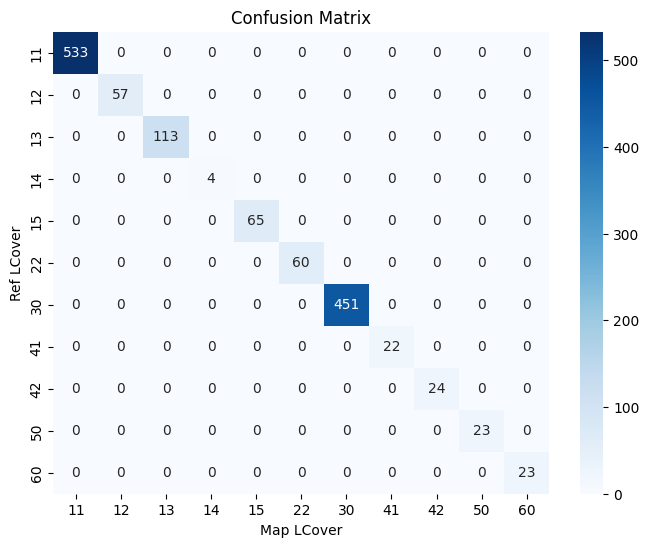

In [158]:
# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='Blues')
plt.ylabel('Ref LCover')
plt.xlabel('Map LCover')
plt.title('Confusion Matrix')
plt.show()

In [74]:
# Select the column from areas_df to use for multiplication, for example, 'Area1'
area_column = areas_df['Area (ha)']

In [75]:
# Convert the selected column to a NumPy array for broadcasting
area_column = area_column.to_numpy()

In [76]:
# Perform element-wise multiplication using broadcasting
weighted_conf_matrix = conf_matrix * area_column[:, np.newaxis]
weighted_conf_matrix

array([[2.68126616e+10, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 1.80987375e+08, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 1.18569430e+09, 0.00000000e+00,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 4.60808693e+07,
        0.00000000e+00, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        1.26669872e+07, 0.00000000e+00],
       [0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
        0.00000000e+00, 2.09236964e+06]])

In [77]:
# Calculate overall accuracy
overall_accuracy = np.trace(weighted_conf_matrix) / np.sum(weighted_conf_matrix)
overall_accuracy

1.0000000000000002

In [78]:
# Calculate user's accuracy (precision) and producer's accuracy (recall)
users_accuracy = np.diag(weighted_conf_matrix) / np.sum(weighted_conf_matrix, axis=0)
users_accuracy

array([1., 1., 1., 1., 1., 1.])

In [79]:
producers_accuracy = np.diag(weighted_conf_matrix) / np.sum(weighted_conf_matrix, axis=1)
producers_accuracy

array([1., 1., 1., 1., 1., 1.])

In [80]:
# Calculate the kappa coefficient
total_sum = np.sum(weighted_conf_matrix)
random_agreement = np.sum(np.sum(weighted_conf_matrix, axis=0) * np.sum(weighted_conf_matrix, axis=1)) / total_sum
kappa = (overall_accuracy - random_agreement) / (1 - random_agreement)

In [81]:
# Create a DataFrame to display the results
results = {
    "Class": labels,
    "User's Accuracy": users_accuracy,
    "Producer's Accuracy": producers_accuracy,
    "Reference Area": area_column
}

acc_df = pd.DataFrame(results)

# Adding Overall Accuracy and Kappa to the DataFrame
acc_df.loc["Overall Accuracy"] = ["-", overall_accuracy, "-", "-"]
acc_df.loc["Kappa"] = ["-", kappa, "-", "-"]

# Display the results
print(acc_df)

                 Class  User's Accuracy Producer's Accuracy Reference Area
0                   10            1.000               1.000   34731426.962
1                   20            1.000               1.000    2919151.203
2                   30            1.000               1.000    8291568.542
3                   40            1.000               1.000    1001758.029
4                   50            1.000               1.000     550738.572
5                   60            1.000               1.000      90972.593
Overall Accuracy     -            1.000                   -              -
Kappa                -            1.000                   -              -


In [82]:
import random

def bootstrap_conf_intervals(data, num_samples=100, alpha=0.05):
    samples = np.random.choice(data, size=(num_samples, len(data)), replace=True)
    metric_means = np.mean(samples, axis=1)
    lower = np.percentile(metric_means, 100 * alpha / 2)
    upper = np.percentile(metric_means, 100 * (1 - alpha / 2))
    return lower, upper

# Compute bootstrap confidence intervals for user's accuracy
user_accuracy_intervals = [bootstrap_conf_intervals(conf_matrix[i, :] / conf_matrix.sum(axis=1)) for i in range(len(conf_matrix))]
producer_accuracy_intervals = [bootstrap_conf_intervals(conf_matrix[:, i] / conf_matrix.sum(axis=0)) for i in range(len(conf_matrix))]
overall_accuracy_interval = bootstrap_conf_intervals([overall_accuracy] * len(conf_matrix))
kappa_interval = bootstrap_conf_intervals([kappa] * len(conf_matrix))

# Compute bootstrap confidence intervals for area calculations
area_intervals = [bootstrap_conf_intervals(areas_df['Area (ha)']) for area in areas_df['Area (ha)']]

In [83]:
results = {
    "Class": labels,
    "User's Accuracy": users_accuracy,
    "User's Accuracy CI": user_accuracy_intervals,
    "Producer's Accuracy": producers_accuracy,
    "Producer's Accuracy CI": producer_accuracy_intervals,
    "Reference Area": areas_df['Area (ha)'],
    "Area CI": area_intervals
}

acc_df = pd.DataFrame(results)

# Adding Overall Accuracy and Kappa to the DataFrame
acc_df.loc["Overall Accuracy"] = ["-", overall_accuracy, overall_accuracy_interval, "-", "-", "-", "-"]
acc_df.loc["Kappa"] = ["-", kappa, kappa_interval, "-", "-", "-", "-"]

# Display the results
acc_df

,Class,User's Accuracy,User's Accuracy CI,Producer's Accuracy,Producer's Accuracy CI,Reference Area,Area CI
0,10,1.000,"(0.0, 0.5)",1.000,"(0.0, 0.5)",34731426.962,"(902328.980065534, 19401126.443459734)"
1,20,1.000,"(0.0, 0.5)",1.000,"(0.0, 0.5)",2919151.203,"(979029.5310250606, 20464301.23604232)"
2,30,1.000,"(0.0, 0.5)",1.000,"(0.0, 0.5)",8291568.542,"(663218.5510542595, 19174162.907732718)"
3,40,1.000,"(0.0, 0.5)",1.000,"(0.0, 0.3333333333333333)",1001758.029,"(863630.0983350342, 16768269.583952773)"
4,50,1.000,"(0.0, 0.5)",1.000,"(0.0, 0.5)",550738.572,"(934174.0519610969, 15162255.27620333)"
5,60,1.000,"(0.0, 0.5)",1.000,"(0.0, 0.5)",90972.593,"(780108.9359709532, 19213627.110206265)"
Overall Accuracy,-,1.000,"(1.0000000000000002, 1.0000000000000002)",-,-,-,-
Kappa,-,1.000,"(1.0, 1.0)",-,-,-,-
